# Parallel ViT-CNN Hybrid with MURA

## GPU Availability Check

We start with GPU availability check.

In [1]:
import tensorflow as tf
import torch

print(f"Tensorflow Version: {tf.__version__}")
print(f"TF GPU Available: {tf.config.list_physical_devices('GPU')}")

print(f"\nPyTourch Version: {torch.__version__}")
print(f"PyTourch GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Tensorflow Version: 2.20.0
TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTourch Version: 2.10.0+cu128
PyTourch GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU


## Dataset loading

We define the Aseptic Loose Hip Implant X-Ray Database dataset,

In [2]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

class HipImplantManager:
    def __init__(self, root_dir='/tf/data/loose_hips'):
        """
        Args:
            root_dir (string): Path to the root folder containing /loose and /control.
        """
        self.root_dir = root_dir
        self.target_classes = ['control', 'loose']
        self.data = []

        # 1. Scan directories and build a list of file paths and class names
        for class_name in self.target_classes:
            class_folder = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_folder):
                print(f"Warning: Folder {class_folder} not found.")
                continue
                
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append({
                        'filepath': os.path.join(class_folder, img_name),
                        'class_name': class_name
                    })

        self.df = pd.DataFrame(self.data)

        # 2. Encode Labels using LabelEncoder
        self.encoder = LabelEncoder()
        # fit_transform converts 'control'/'loose' into 0/1 (alphabetically or by order of appearance)
        self.df['label'] = self.encoder.fit_transform(self.df['class_name'])
        
        print(f"Loaded {len(self.df)} images.")
        print("Class Mapping:")
        for idx, cls in enumerate(self.encoder.classes_):
            print(f"{idx}: {cls}")

    def get_splits(self, train_size=0.8, val_size=0.1, test_size=0.1):
        """
        Splits the dataset into train, validation, and test sets.
        Uses stratified splitting to ensure balanced classes in each split.
        """
        # Split into Train and Temp (Val + Test)
        train_df, temp_df = train_test_split(
            self.df, 
            train_size=train_size, 
            stratify=self.df['label'], 
            random_state=42
        )

        # Split Temp into Val and Test
        relative_val_size = val_size / (val_size + test_size)
        val_df, test_df = train_test_split(
            temp_df, 
            train_size=relative_val_size, 
            stratify=temp_df['label'], 
            random_state=42
        )

        return train_df, val_df, test_df

class HipImplantDataset(Dataset):
    def __init__(self, dataframe, transform=None, factor=1):
        self.df = dataframe
        self.transform = transform
        self.factor = factor

    def __len__(self):
        return len(self.df) * self.factor

    def __getitem__(self, idx):
        # Use modulo to map the expanded index back to a valid dataframe row
        actual_idx = idx % len(self.df)
        
        row = self.df.iloc[actual_idx]
        img_path = row['filepath']
        label = row['label']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback for missing/corrupt files
            print(f"Warning: Could not load {img_path}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

.. and define custom resize transformation,

In [3]:
from torchvision import transforms
import torchvision.transforms.functional as TF

class LetterboxResize:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def __call__(self, img):
        # 1. Resize the image such that the longest side matches target_size
        w, h = img.size
        max_side = max(self.target_size)
        scale = max_side / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = TF.resize(img, (new_h, new_w))

        # 2. Pad the shorter side to make it square
        delta_w = self.target_size[0] - new_w
        delta_h = self.target_size[1] - new_h
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Use a constant background color (black or gray)
        return TF.pad(img, padding, fill=0, padding_mode='constant')

.. and from such definition, we instantiate datasets.

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 1. Initialize Manager
manager = HipImplantManager('/tf/data/loose_hips') 
train_df, val_df, test_df = manager.get_splits()

# 2. Define Transforms (Reusing LetterboxResize from your notebook)
train_transform = transforms.Compose([
    # 1. Geometric Augmentations (Patient positioning varies)
    LetterboxResize(target_size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),

    # 2. Key for Generalization: Random Crop
    # Forces model to classify based on parts of the implant, not just the whole picture
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    
    # 3. Intensity Augmentations (X-ray exposure varies)
    # Note: Hue/Saturation are 0 because X-rays are grayscale
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),

    transforms.ToTensor(),
    
    # 4. Normalization (Must match the MURA/ImageNet stats used in pre-training)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    # 5. Regularization for ViTs
    # Randomly blacks out a rectangle. Helps prevent the model from relying on
    # specific artifacts (like a text marker or a specific bone spur).
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

val_test_transform = transforms.Compose([
    LetterboxResize(target_size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Create Dataset Objects
train_ds = HipImplantDataset(train_df, transform=train_transform, factor=20)
val_ds = HipImplantDataset(val_df, transform=val_test_transform)
test_ds = HipImplantDataset(test_df, transform=val_test_transform)

# 4. Create Loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

Loaded 206 images.
Class Mapping:
0: control
1: loose
Train size: 3280 | Val size: 21 | Test size: 21


## Training

We define training step,

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Update signature to accept 'scheduler'
def train_one_epoch(model, loader, criterion, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Conformer outputs: [logits_cnn, logits_trans]
        out_cnn, out_trans = model(images)

        # Combined loss as suggested in Conformer paper
        loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

        loss.backward()

        # [Recommended] Gradient Clipping
        # Helps prevent "exploding gradients" common in Transformers
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # [Critical for OneCycleLR] Step the scheduler after every batch
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()

        # Prediction logic remains the same (Ensemble of CNN + Trans)
        prob_cnn = torch.softmax(out_cnn, dim=1)
        prob_trans = torch.softmax(out_trans, dim=1)
        prediction = (prob_cnn + prob_trans).argmax(dim=1)

        correct += (prediction == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. and validation step,

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm 

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            out_cnn, out_trans = model(images)
            loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

            total_loss += loss.item()
           
            # pengzhiliang: prediction = (out_cnn + out_trans).argmax(dim=1)
    
            prob_cnn = torch.softmax(out_cnn, dim=1)
            prob_trans = torch.softmax(out_trans, dim=1)
            prediction = (prob_cnn + prob_trans).argmax(dim=1)
            
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. silence warning

In [7]:
import warnings
warnings.filterwarnings("ignore")

.. and perform training

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import sys
import os

# Initialize lists to store history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# --- 2. Setup & Model Initialization ---
path_to_conformer = os.path.abspath('./Conformer')
if path_to_conformer not in sys.path:
    sys.path.insert(0, path_to_conformer)

from models import Conformer_small_patch16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer_small_patch16(num_classes=7).to(DEVICE)

# Load MURA weights (if available)
mura_weights_path = 'best_conformer_mura.pth'
if os.path.exists(mura_weights_path):
    model.load_state_dict(torch.load(mura_weights_path, map_location=DEVICE))
    print(f"Successfully loaded MURA pre-trained weights.")

# --- 3. Initial Freezing (Warmup Phase) ---
# Freeze ALL parameters first
for param in model.parameters():
    param.requires_grad = False

# Replace Heads for 2 classes (Control vs Loose)
model.trans_cls_head = nn.Linear(model.trans_cls_head.in_features, 2).to(DEVICE)
model.conv_cls_head = nn.Linear(model.conv_cls_head.in_features, 2).to(DEVICE)

# Define Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initial Optimizer (Only optimizes the Heads for Stage 1)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.1)

# --- 4. Training Hyperparameters ---
max_epochs = 50
UNFREEZE_EPOCH = 10
patience = 8
min_delta = 0.001

best_val_acc = 0.0
early_stop_counter = 0
best_val_loss = float('inf')
scheduler = None # Initialize as None for Stage 1

print(f"Starting Stage 1: Training Heads only for {UNFREEZE_EPOCH} epochs...")

# --- 5. Training Loop ---
for epoch in range(max_epochs):

    # === UNFREEZE LOGIC (Start Stage 2) ===
    if epoch == UNFREEZE_EPOCH:
        print(f"\n>>> [Epoch {epoch}] Unfreezing Backbone! Switching to OneCycleLR.")

        # 1. Unfreeze all parameters
        for param in model.parameters():
            param.requires_grad = True

        # 2. Re-initialize Optimizer with Parameter Groups
        # Group 0: Trans Head (lr=1e-4)
        # Group 1: Conv Head  (lr=1e-4)
        # Group 2: Backbone   (lr=1e-5) -> Slightly lower for feature extraction
        optimizer = torch.optim.AdamW([
            {'params': model.trans_cls_head.parameters(), 'lr': 1e-4},
            {'params': model.conv_cls_head.parameters(),  'lr': 1e-4},
            {'params': [p for n, p in model.named_parameters()
                        if "cls_head" not in n],          'lr': 1e-5}
        ])

        # 3. Initialize OneCycleLR
        # We calculate remaining steps for the scheduler
        remaining_epochs = max_epochs - UNFREEZE_EPOCH

        scheduler = OneCycleLR(
            optimizer,
            max_lr=[1e-4, 1e-4, 1e-5],     # Peak LRs matching the optimizer groups
            epochs=remaining_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3,                 # 30% of time spending warming up
            div_factor=25.0,               # Initial LR = max_lr / 25
            final_div_factor=1000.0        # Final LR = Initial LR / 1000
        )

    # Run Training Step (Pass scheduler only if it exists)
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE, scheduler
    )

    # Note: We NO LONGER step the scheduler here. It is stepped inside train_one_epoch.

    # Monitor Learning Rate (Optional)
    if scheduler:
        current_lr = optimizer.param_groups[2]['lr'] # Backbone LR
        # print(f"  Current Backbone LR: {current_lr:.2e}") # Uncomment if verbose logging needed

    # Run Validation Step
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Save Best Model (Based on Accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_conformer_loose_hips_mura_pretrained.pth')
        print("  --> New Best Model Checkpointed!")
        early_stop_counter = 0

    # Early Stopping Logic
    if epoch >= UNFREEZE_EPOCH:
        if val_loss < (best_val_loss - min_delta):
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"  --> Early stopping counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"\n[!] Early stopping triggered at epoch {epoch}.")
            break

### Plot training history

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(len(history['train_loss']))
    
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='#1f77b4', lw=2)
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='#ff7f0e', lw=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color='#1f77b4', lw=2)
    plt.plot(epochs, history['val_acc'], label='Val Acc', color='#ff7f0e', lw=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Execute plotting
plot_training_history(history)

### Restore best weights

In [8]:
import sys
import os

path_to_conformer = os.path.abspath('./Conformer')
if path_to_conformer not in sys.path:
    sys.path.insert(0, path_to_conformer)
    
from models import Conformer_small_patch16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer_small_patch16(num_classes=2).to(DEVICE)

In [9]:
# Load the best weights back into the model for evaluation
model.load_state_dict(torch.load('best_conformer_loose_hips_mura_pretrained.pth'))
model.to(DEVICE)
model.eval()
print("Best model weights loaded successfully!")

Best model weights loaded successfully!


## Evaluation

### Confusion matrix

We evaluate model by plotting confusion matrix,

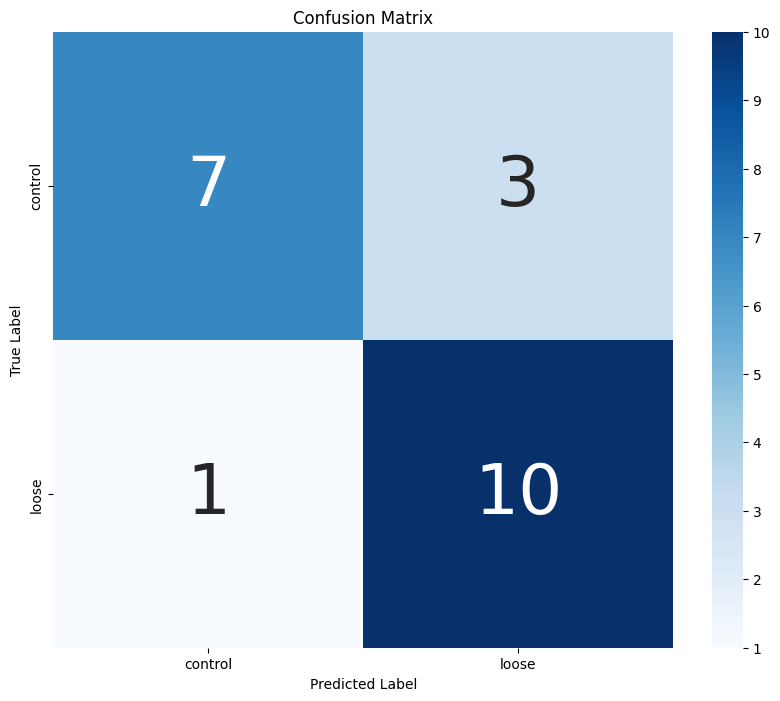


Classification Report:

              precision    recall  f1-score   support

     control       0.88      0.70      0.78        10
       loose       0.77      0.91      0.83        11

    accuracy                           0.81        21
   macro avg       0.82      0.80      0.81        21
weighted avg       0.82      0.81      0.81        21



In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Conformer dual-output handling: average the branches for prediction
            out_cnn, out_trans = model(images)
            outputs = (out_cnn + out_trans) / 2

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 50})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Also print the detailed F1-score/Recall report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Usage:
# Get names from the encoder we defined in the Manager class
class_names = manager.encoder.classes_
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

.. also plot PR-curve,

### POC curve

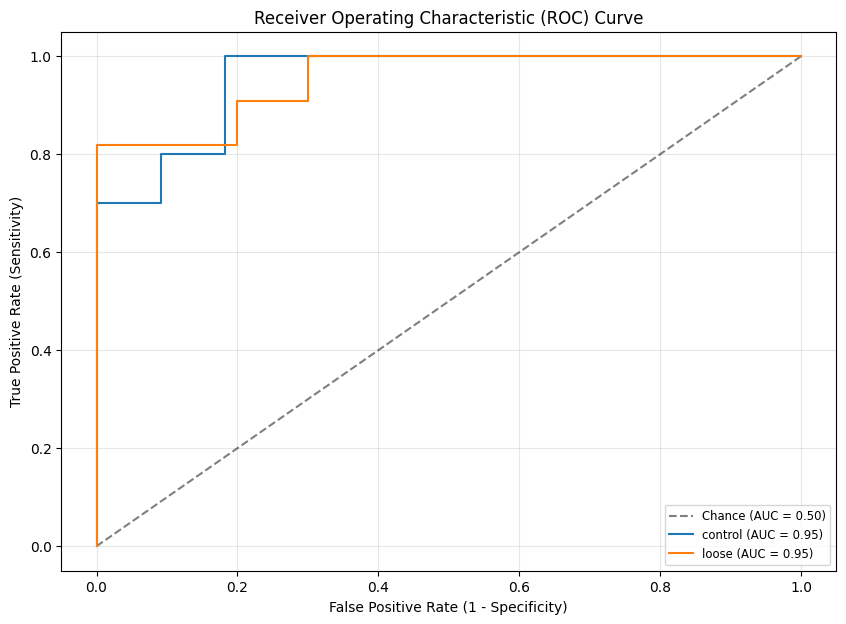

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_curve(model, loader, device, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Handling the hybrid model output
            out_cnn, out_trans = model(images)
            # Use averaged probabilities
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    y_true = np.concatenate(all_labels)
    Y_score = np.concatenate(all_probs)
    n_classes = len(class_names)

    # Standardize label format for multiclass/binary
    if n_classes == 2:
        Y_test = np.zeros((len(y_true), 2))
        Y_test[np.arange(len(y_true)), y_true] = 1
    else:
        Y_test = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 7))

    # Plot diagonal "chance" line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Chance (AUC = 0.50)')

    for i in range(n_classes):
        # Calculate False Positive Rate and True Positive Rate
        fpr, tpr, _ = roc_curve(Y_test[:, i], Y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(alpha=0.3)
    plt.show()

# Usage:
plot_roc_curve(model, test_loader, DEVICE, manager.encoder.classes_)

## Explanation

Let's try to explain how our model works.

### GradCAM for CNN branch

We start with explaining how CNN branch works with Grad-CAM,

Targeting layer: Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))


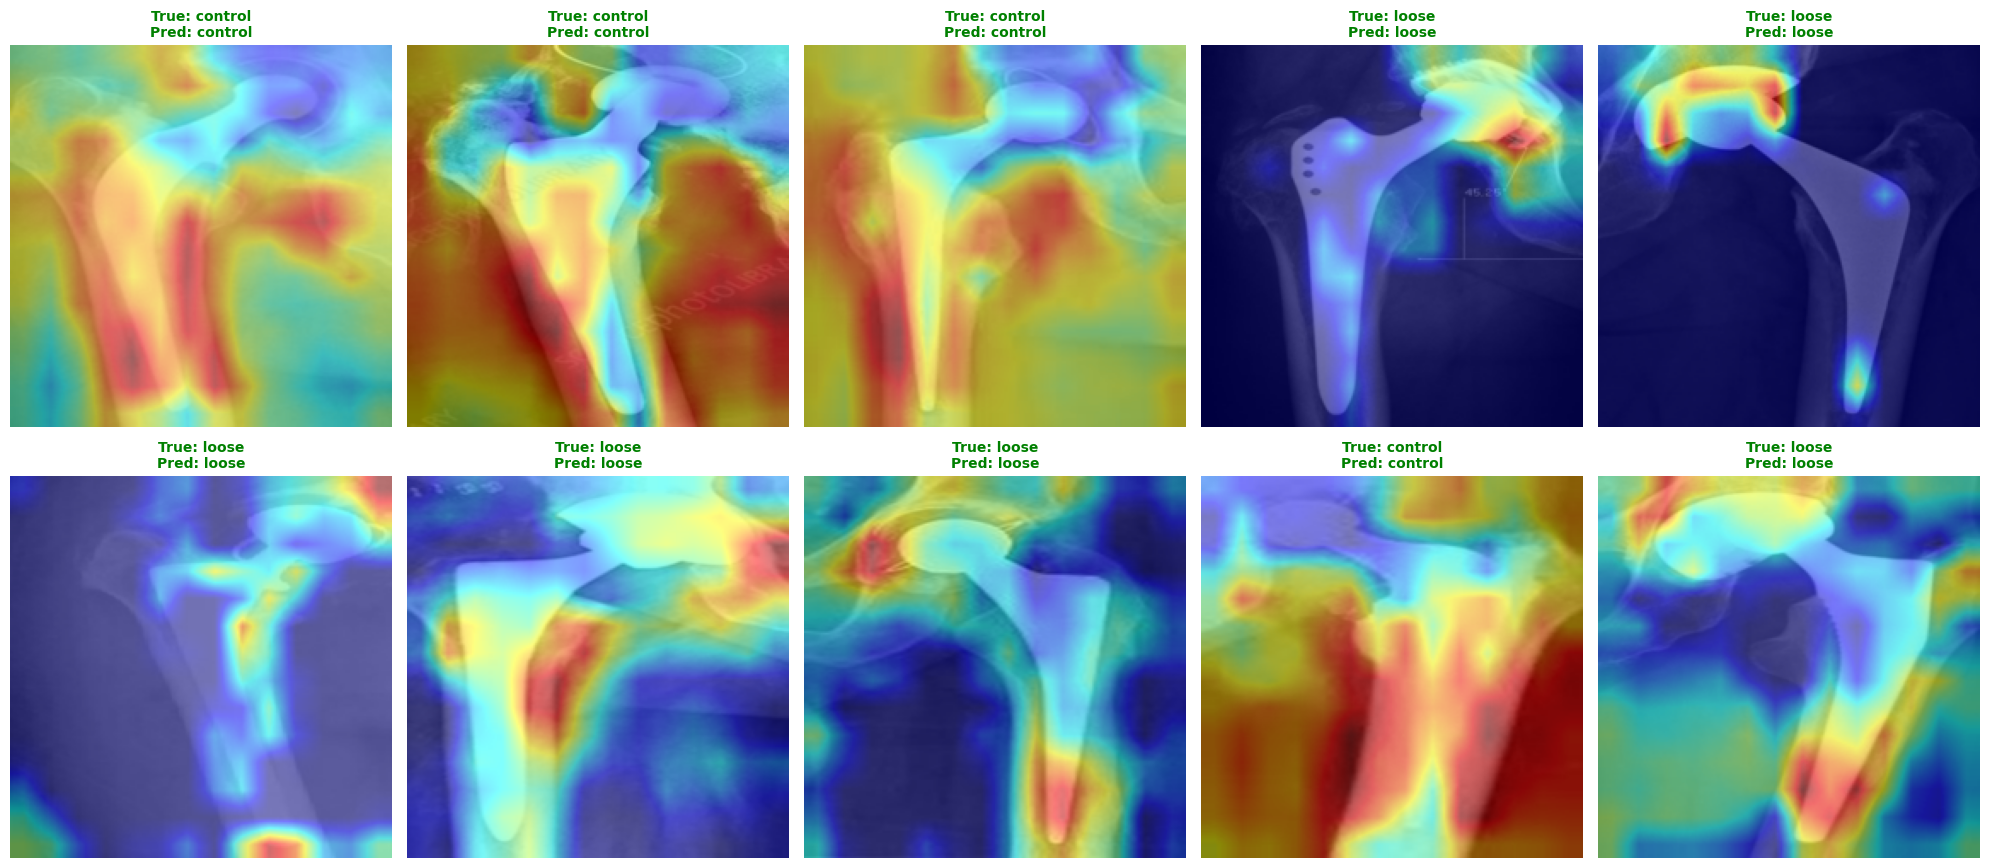

In [12]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Wrapper to isolate the CNN output for GradCAM
# The Conformer model returns (out_cnn, out_trans). GradCAM expects a single tensor output.
class CNNBranchWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        out_cnn, _ = self.model(x)
        return out_cnn

# 2. Setup GradCAM
# Use the wrapper model
wrapped_model = CNNBranchWrapper(model)

# Automatically find the last 2D convolution layer for the target
def get_last_conv_layer(m):
    last_conv = None
    for name, module in m.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    return last_conv

target_layer = get_last_conv_layer(model)
# If specific layer needed, try: model.conv_block.layer_name...
# For now, auto-detection or the last found conv usually works best for general CNNs.
target_layers = [target_layer] if target_layer else None

cam = GradCAM(model=wrapped_model, target_layers=target_layers)

# 3. Get Class Names
class_names = manager.encoder.classes_

# 4. Visualization Loop
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Prepare plot
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()

print(f"Targeting layer: {target_layer}")

for i in range(num_images):
    if i >= len(images): break

    # Prepare input
    img_tensor = images[i].unsqueeze(0).to(DEVICE)
    label_idx = labels[i].item()

    # Generate GradCAM
    # We target the specific class index of the ground truth label
    targets = [ClassifierOutputTarget(label_idx)]
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

    # Prepare background image (Denormalize for display)
    rgb_img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_img = std * rgb_img + mean
    rgb_img = np.clip(rgb_img, 0, 1)

    # Overlay Heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Get Prediction for Title
    with torch.no_grad():
        out_cnn, out_trans = model(img_tensor)
        # Average prediction from both branches
        pred_idx = (out_cnn + out_trans).argmax(dim=1).item()

    # Plotting
    ax = axes[i]
    ax.imshow(visualization)

    title_color = 'green' if pred_idx == label_idx else 'red'
    ax.set_title(f"True: {class_names[label_idx]}\nPred: {class_names[pred_idx]}",
                 color=title_color, fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Attention Rollout for Transformer branch

.. the we explain transformer with Attention Rollout,

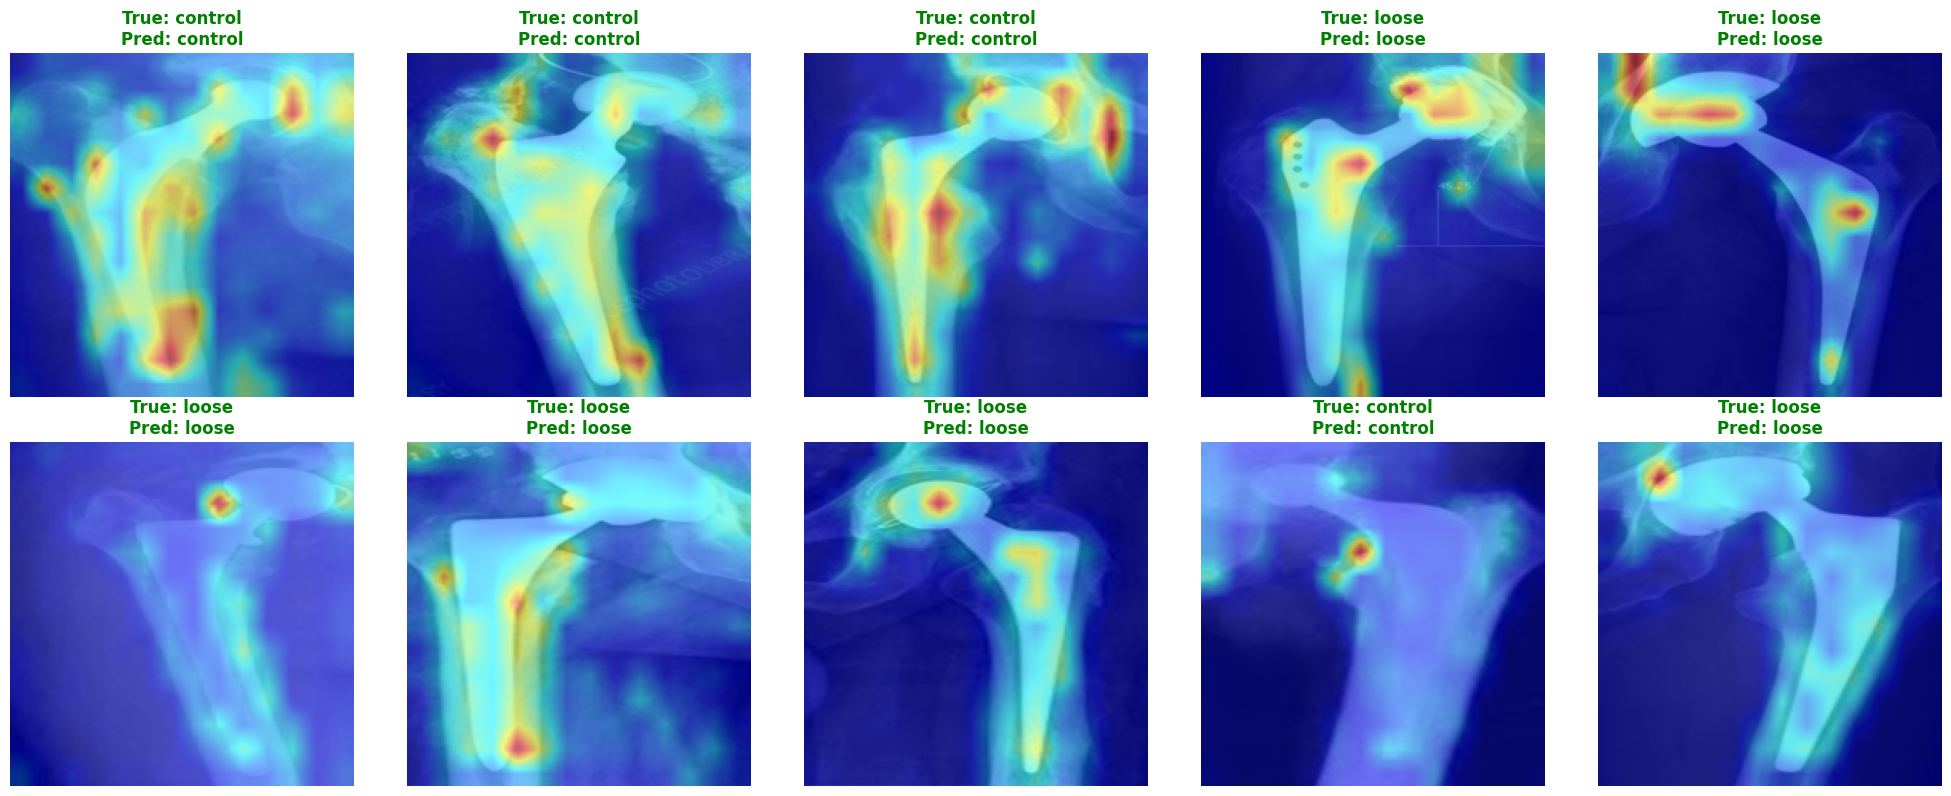

In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# =========================================================
# 1. Attention Rollout Helper
# =========================================================
class AttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop'):
        self.model = model
        self.attention_layer_name = attention_layer_name
        self.hooks = []
        self.attentions = []

        # Register hooks on attention dropout layers
        for name, module in self.model.named_modules():
            if self.attention_layer_name in name:
                self.hooks.append(
                    module.register_forward_hook(self.get_attention)
                )

        if len(self.hooks) == 0:
            raise RuntimeError(f"No layers found with name containing '{attention_layer_name}'")

    def get_attention(self, module, input, output):
        # output shape: [B, heads, tokens, tokens]
        self.attentions.append(output.detach())

    def __call__(self, input_tensor):
        self.attentions = []

        with torch.no_grad():
            _ = self.model(input_tensor)

        # ---- Attention Rollout ----
        # Start from identity
        device = self.attentions[0].device
        num_tokens = self.attentions[0].size(-1)
        rollout = torch.eye(num_tokens, device=device)

        for attn in self.attentions:
            # Fuse heads
            attn_fused = attn.mean(dim=1)[0]  # [tokens, tokens]

            # Residual connection + normalization
            attn_fused = attn_fused + torch.eye(num_tokens, device=device)
            attn_fused = attn_fused / attn_fused.sum(dim=-1, keepdim=True)

            rollout = attn_fused @ rollout

        # CLS token attention to patch tokens
        mask = rollout[0, 1:]

        # Reshape to patch grid (ViT-style: 14x14 for 224x224, patch=16)
        grid_size = int(np.sqrt(mask.shape[0]))
        mask = mask.reshape(grid_size, grid_size)

        # Normalize and resize to image size
        mask = mask / mask.max()
        mask = cv2.resize(
            mask.cpu().numpy(),
            (input_tensor.shape[3], input_tensor.shape[2])
        )

        return mask

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()


# =========================================================
# 2. Configuration
# =========================================================
num_images = 10
rows, cols = 2, 5

DEVICE = next(model.parameters()).device
model.eval()

rollout = AttentionRollout(model, attention_layer_name='attn_drop')

# =========================================================
# 3. Visualization
# =========================================================
plt.figure(figsize=(20, 8))

for i in range(num_images):
    img_tensor = images[i].unsqueeze(0).to(DEVICE)
    true_label_idx = labels[i].item()
    true_label = class_names[true_label_idx]

    # ---- Prediction ----
    with torch.no_grad():
        out_cnn, out_trans = model(img_tensor)
        logits = (out_cnn + out_trans) / 2
        pred_label_idx = logits.argmax(dim=1).item()
        pred_label = class_names[pred_label_idx]

    # ---- Attention Rollout ----
    try:
        mask = rollout(img_tensor)
    except Exception as e:
        print(f"Rollout failed for image {i}: {e}")
        continue

    # ---- Prepare image for plotting ----
    img_viz = img_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    img_viz = (img_viz - img_viz.min()) / (img_viz.max() - img_viz.min() + 1e-8)

    # ---- Heatmap overlay ----
    heatmap = cv2.applyColorMap(
        np.uint8(255 * mask),
        cv2.COLORMAP_JET
    )
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    overlay = 0.5 * img_viz + 0.5 * heatmap
    overlay = overlay / overlay.max()

    # ---- Plot ----
    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    color = 'green' if true_label_idx == pred_label_idx else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color=color, fontweight='bold')
    plt.axis('off')

# =========================================================
# 4. Cleanup
# =========================================================
rollout.remove_hooks()
plt.tight_layout()
plt.show()